## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.layers import Dense, Flatten, Dropout,GlobalAveragePooling2D,Input
from tensorflow.python.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop, Adadelta

In [3]:
tf.__version__

'1.13.1'

In [5]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
#hyperparameters
HYPERPARAMS = {'WEIGHTS': 'imagenet', 'EPOCHS': 5, 'BATCHSIZE': 20, 'LEARN_RATE': 0.00001, 'DROPOUT': 0.5, 'TRAIN_LAYERS': 4}

#Adam(lr=HYPERPARAMS['LEARN_RATE'])

 ### Save settings in file

In [6]:
import os
import datetime

now = datetime.datetime.now()
training_time = now.strftime("%Y%m%d_%H%M")

# name of dir due to today date
TRAINING_TIME_PATH = "saved_models/" + training_time
TRAINING_TIME_PATH

# define the access rights
access_rights = 0o755

try:  
    os.makedirs(TRAINING_TIME_PATH, access_rights)
except OSError:  
    print ("Creation of the directory %s failed" % TRAINING_TIME_PATH)
else:  
    print ("Successfully created the directory %s" % TRAINING_TIME_PATH)
    
    


Successfully created the directory saved_models/20190501_1559


In [7]:
import json

with open(TRAINING_TIME_PATH+'/hyperparams.json', 'w') as f:
    json.dump(HYPERPARAMS, f)

## Import base model

In [8]:
base_model = ResNet50(weights=HYPERPARAMS['WEIGHTS'], 
                      include_top=False, input_shape=(224,224,3))

# if include_top=False, input shape should be specified as a parameter
input_shape = base_model.layers[0].output_shape[1:3]
input_shape 

#base_model = VGG16(weights='imagenet', 
                      #include_top=False)
#base_model.output
base_model.summary()



Instructions for updating:
Colocations handled automatically by placer.


/home/kamila/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
# take the last layer and set it as transfer layer
transfer_layer = base_model.get_layer(index=-1)
transfer_layer.output

<tf.Tensor 'activation_48/Relu:0' shape=(?, 7, 7, 2048) dtype=float32>

In [10]:
base_model.output_shape

(None, 7, 7, 2048)

## Helper Functions

### Helper-function for joining a directory and list of filenames.

In [11]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    '''Function used to plot at most 9 images in a 3x3 grid, 
    and writing the true and predicted classes below each image.'''
    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.9
    else:
        hspace = 2.0
    fig.subplots_adjust(hspace=hspace, wspace=0.6)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: \n{0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: \n{0}\n\nPred: \n{1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    '''Helper-function for printing confusion matrix'''
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        
        
def plot_example_errors(cls_pred):
    '''Function for plotting examples of images from the test-set that have been mis-classified.'''
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
    
def example_errors(new_model):
    '''The Keras data-generator for the test-set must be reset
    before processing. This is because the generator will loop
    infinitely and keep an internal index into the dataset.
    So it might start in the middle of the test-set if we do
    not reset it first. This makes it impossible to match the
    predicted classes with the input images.
    If we reset the generator, then it always starts at the
    beginning so we know exactly which input-images were used.'''
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)
    
    
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)


def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

## Dataset


In [12]:
train_dir = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_s/train'
test_dir = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_s/test'


datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')



datagen_test = ImageDataGenerator(rescale=1./255)

batch_size = HYPERPARAMS['BATCHSIZE']

if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'
    
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)    
steps_per_epoch = generator_train.n / batch_size
                    
                    
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

steps_test = generator_test.n / batch_size
#steps_test

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

cls_train = generator_train.classes
cls_test = generator_test.classes
#print(cls_train)
#print(cls_test)

class_names = list(generator_train.class_indices.keys())
print(class_names)

num_classes = generator_train.num_classes
#num_classes

Found 122 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
['Audi A5 Coupe 2012', 'BMW X3 SUV 2012', 'Dodge Caliber Wagon 2007']


### Plot a few images to see if data is correct

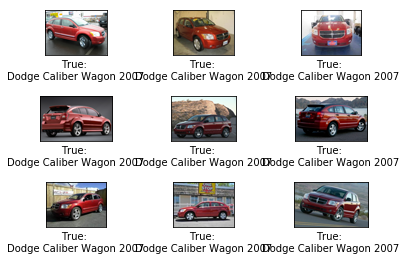

In [13]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[100:109])

# Get the true classes for those images.
cls_true = cls_train[100:109]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

The dataset is quite imbalanced which can cause a problem during training.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

## Transfer Learning



We can then use Keras to build a new model on top of this.

In [15]:
def build_finetune_model(base_model, transfer_layer, x_trainable, dropout, fc_layers, num_classes):
    for layer in base_model.layers[:-x_trainable]:
        layer.trainable = False

    x = transfer_layer.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model


FC_LAYERS = [1024, 1024]
dropout = HYPERPARAMS['DROPOUT']

finetune_model = build_finetune_model(base_model, transfer_layer, HYPERPARAMS['TRAIN_LAYERS'], 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes= num_classes)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
# Check the trainable status of the individual layers
for layer in finetune_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe8175b5390> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fe8175b54e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe8175b55c0> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7fe8175b5668> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe8175b5a90> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fe8175631d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe817586828> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe817586e48> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7fe8174c1550> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe8174c1d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe80adb3f60> False
<tensorflow.python.keras.layers

In [18]:
for layer in base_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe8175b5390> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fe8175b54e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe8175b55c0> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7fe8175b5668> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe8175b5a90> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fe8175631d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fe817586828> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe817586e48> False
<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7fe8174c1550> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fe8174c1d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe80adb3f60> False
<tensorflow.python.keras.layers

In [19]:
optimizer = Adam(lr=HYPERPARAMS['LEARN_RATE'])
finetune_model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

We use the Adam optimizer with a fairly low learning-rate. The learning-rate could perhaps be larger. But if you try and train more layers of the original VGG16 model, then the learning-rate should be quite low otherwise the pre-trained weights of the VGG16 model will be distorted and it will be unable to learn.

In [18]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau, TensorBoard

tensor_board = TensorBoard(log_dir=TRAINING_TIME_PATH+'/logs', histogram_freq=0, write_graph=True, write_images=True)
log_file_path = TRAINING_TIME_PATH + '/logs/training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_acc', patience=patience)
reduce_lr = ReduceLROnPlateau('val_acc', factor=0.1, patience=int(patience / 4), verbose=1)
trained_models_path = TRAINING_TIME_PATH+'/models/model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_acc', verbose=1, save_best_only=True)
callbacks = [tensor_board, model_checkpoint, csv_logger, early_stop, reduce_lr]


Using TensorFlow backend.


NameError: name 'patience' is not defined

An epoch normally means one full processing of the training-set. But the data-generator that we created above, will produce batches of training-data for eternity. So we need to define the number of steps we want to run for each "epoch" and this number gets multiplied by the batch-size defined above. In this case we have 100 steps per epoch and a batch-size of 20, so the "epoch" consists of 2000 random images from the training-set. We run 20 such "epochs".

The reason these particular numbers were chosen, was because they seemed to be sufficient for training with this particular model and dataset, and it didn't take too much time, and resulted in 20 data-points (one for each "epoch") which can be plotted afterwards.

Training the new model is just a single function call in the Keras API. This takes about 6-7 minutes on a GTX 1070 GPU.

In [20]:
#history = finetune_model.fit_generator(generator_train, epochs=NUM_EPOCHS, workers=8, 
                                       #steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       #shuffle=True, callbacks=callbacks_list)

epochs = HYPERPARAMS['EPOCHS']
steps_per_epoch = generator_train.n / HYPERPARAMS['BATCHSIZE']

history = finetune_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)



Instructions for updating:
Use tf.cast instead.
Epoch 1/5
7/7 [==============================] - 66s 9s/step - loss: 2.2815 - acc: 0.3279 - val_loss: 1.1060 - val_acc: 0.3223
Epoch 2/5
7/7 [==============================] - 60s 9s/step - loss: 2.1962 - acc: 0.4590 - val_loss: 1.1550 - val_acc: 0.3388
Epoch 3/5
7/7 [==============================] - 60s 9s/step - loss: 1.9791 - acc: 0.4836 - val_loss: 1.2175 - val_acc: 0.3388
Epoch 4/5
7/7 [==============================] - 66s 9s/step - loss: 1.3570 - acc: 0.5082 - val_loss: 1.2779 - val_acc: 0.3388
Epoch 5/5
7/7 [==============================] - 61s 9s/step - loss: 1.7888 - acc: 0.4098 - val_loss: 1.3342 - val_acc: 0.3388


Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This shows that the loss-value for the training-set generally decreased during training, but the loss-values for the test-set were a bit more erratic. Similarly, the classification accuracy generally improved on the training-set while it was a bit more erratic on the test-set.

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


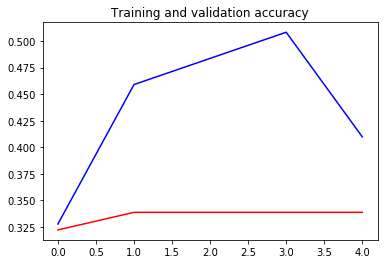

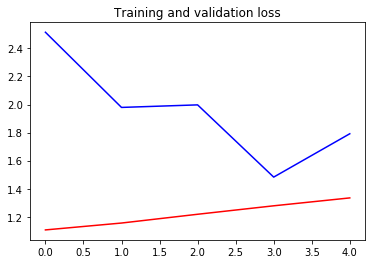

OSError: [Errno 28] No space left on device

<Figure size 432x288 with 0 Axes>

In [22]:
import json,codecs
import numpy as np

def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n



def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.title('Training and validation loss')
    plt.show()
    plt.savefig('acc_vs_epochs.png')

#plot_training(history)
#saveHist(TRAINING_TIME_PATH+'/history.txt', history)


# Save the model
#finetune_model.save(TRAINING_TIME_PATH+'/vgg16_.h5')


with open(TRAINING_TIME_PATH+'/history.txt', 'w') as f:  
    f.write(str(history.history))
    
    
plot_training(history)
print(str(history.history))

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [23]:
result = finetune_model.evaluate_generator(generator_test, steps=steps_test)
result_train = finetune_model.evaluate_generator(generator_train, steps=steps_per_epoch)
print("Train-set classification accuracy: {0:.2%}".format(result_train[1]))
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Train-set classification accuracy: 33.61%
Test-set classification accuracy: 33.88%


We can plot some examples of mis-classified images from the test-set. Some of these images are also difficult for a human to classify.

The confusion matrix shows that the new model is especially having problems classifying the forky-class.

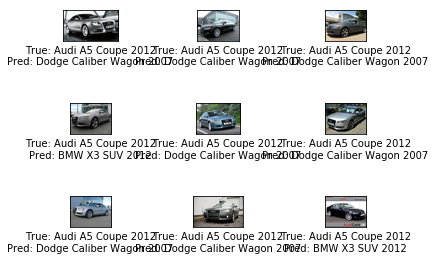

Confusion matrix:
[[21  4 16]
 [11  1 26]
 [11  1 30]]
(0) Audi A5 Coupe 2012
(1) BMW X3 SUV 2012
(2) Dodge Caliber Wagon 2007


In [27]:
example_errors(finetune_model)

In [30]:
from keras.preprocessing import image

def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

def decode_predictions(preds, top=3):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_path, model):
    img_array = load_image(img_path)
    pred = model.predict(img_array)
    print(decode_predictions(pred))
    # Decode the output of the VGG16 model.
    #pred_decoded = decode_predictions(pred)[0]

    ## Print the predictions.
    #for code, name, score in pred_decoded:
        #print("{0:>6.2%} : {1}".format(score, name))

        
        
test_img = '../test_imgs/f.png'
model_path = TRAINING_TIME_PATH+'vgg16_.h5'
model = load_model(model_path)
#load_image(test_img)
predict(test_img, model)

OSError: Unable to open file (unable to open file: name = 'saved_models/20190430_1202vgg16_.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)